In [1]:
import os
import os.path as osp
import sys
sys.path.insert(0, osp.dirname(osp.abspath('.')))

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from model.yolov3 import YOLOv3
from data.dataset import YOLODataset, PASCAL_CLASSES
from data.transform import get_yolo_transform
from utils.convert import cells_to_boxes, xywh2tlbr
from utils.cleanup import nms_by_class
from utils.display import draw_boxes

%load_ext autoreload
%autoreload 2

## Hyperparameter

In [3]:
CSV_PATH = "../download/PASCAL_VOC/test.csv"
IMG_DIR = "../download/PASCAL_VOC/images/"
LABEL_DIR = "../download/PASCAL_VOC/labels/"

In [4]:
DEVICE = "cuda:0"
IMG_SIZE = 416
SCALES = [13, 26, 52]
ANCHORS = [
    [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
    [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
    [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)],
] # (3, 3, 2)

In [5]:
CHECKPOINT_PATH = "../run/yolov3_voc_baseline/best.pth"

## Prepare Dataset

In [6]:
transform = get_yolo_transform(img_size=IMG_SIZE, mode='test')
dataset = YOLODataset(csv_file=CSV_PATH,
                      img_dir=IMG_DIR,
                      label_dir=LABEL_DIR,
                      anchors=ANCHORS,
                      transform=transform)

## Random Sampling Data From Dataset

In [7]:
indices = np.arange(0, len(dataset))
sample_indices = np.random.choice(indices, 9, replace=False)

In [8]:
candidates = []
for sample_idx in sample_indices:
    img, targets = dataset[sample_idx]
    img = img.to(DEVICE)
    target_s1 = targets[0].unsqueeze(0).to(DEVICE)  # (N, 3, 13, 13, 6)         
    target_s2 = targets[1].unsqueeze(0).to(DEVICE)  # (N, 3, 26, 26, 6)         
    target_s3 = targets[2].unsqueeze(0).to(DEVICE)  # (N, 3, 52, 52, 6)         
    targets = [ target_s1, target_s2, target_s3 ]
    candidates.append((img, targets))

## Load Pretrained Model

In [9]:
model = YOLOv3(in_channels=3, num_classes=20)
checkpoint = torch.load(CHECKPOINT_PATH)
model.load_state_dict(checkpoint['model'])
model = model.to(DEVICE)
model = model.eval()

In [10]:
scale = torch.tensor(SCALES).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2) # (3, 3, 2)
scaled_anchors = torch.tensor(ANCHORS)*scale # (3, 3, 2)
scaled_anchors = scaled_anchors.to(DEVICE)

## Perform Model Prediction

In [11]:
PREDICTION_CONF_THRESHOLD = 0.8

predict = []
for candidate in candidates:
    # Prediction on single image
    img = candidate[0]
    targets = candidate[1]
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            preds = model(img.unsqueeze(0))
    # Collect Bounding boxes
    true_bboxes = []
    pred_bboxes = []
    for scale_idx, (pred, target) in enumerate(zip(preds, targets)):                                              
        scale = pred.size(2)   
        anchors = scaled_anchors[scale_idx] # (3, 2)
        anchors = anchors.reshape(1, 3, 1, 1, 2) # (1, 3, 1, 1, 2)                                                                                                                   
        # Convert prediction to correct format                          
        pred[..., 0:2] = torch.sigmoid(pred[..., 0:2])      # (N, 3, S, S, 2)
        pred[..., 2:4] = torch.exp(pred[..., 2:4])*anchors  # (N, 3, S, S, 2)
        pred[..., 4:5] = torch.sigmoid(pred[..., 4:5])      # (N, 3, S, S, 1)
        pred_cls_probs = F.softmax(pred[..., 5:], dim=-1)   # (N, 3, S, S, C)
        probs, indices = torch.max(pred_cls_probs, dim=-1)  # (N, 3, S, S)
        indices = indices.unsqueeze(-1)                     # (N, 3, S, S, 1)
        pred = torch.cat([ pred[..., :5], indices ], dim=-1)# (N, 3, S, S, 6)
        # Convert coordinate system to normalized format (xywh)         
        pboxes = cells_to_boxes(cells=pred, scale=scale)    # (N, 3, S, S, 6)
        tboxes = cells_to_boxes(cells=target, scale=scale)  # (N, 3, S, S, 6)
        # Filter out bounding boxes with confidence threshold
        pred_mask = pboxes[..., 4] > PREDICTION_CONF_THRESHOLD
        true_mask = tboxes[..., 4] == 1.
        pred_boxes = pboxes[pred_mask]
        true_boxes = tboxes[true_mask]
        pred_bboxes.extend(pred_boxes.detach().cpu().numpy().tolist())
        true_bboxes.extend(true_boxes.detach().cpu().numpy().tolist())
    
    # Collect prediction
    predict.append((img.detach().cpu(), pred_bboxes, true_bboxes))

## Perform NMS

In [12]:
nms_predict = []
for img, pred_bboxes, true_bboxes in predict:
    nms_pred_bboxes = []
    nms_true_bboxes = []
    for c in range(20):
        nms_pred_boxes = nms_by_class(target=c,
                                      bboxes=torch.tensor(pred_bboxes),
                                      iou_threshold=0.4)
        nms_true_boxes = nms_by_class(target=c,
                                      bboxes=torch.tensor(true_bboxes),
                                      iou_threshold=0.4)
        nms_pred_bboxes.extend(nms_pred_boxes)
        nms_true_bboxes.extend(nms_true_boxes)
    nms_predict.append((img, nms_pred_bboxes, nms_true_bboxes))

## Visualize Detection Result

In [13]:
inverse = T.ToPILImage()

### Visualize Prediction

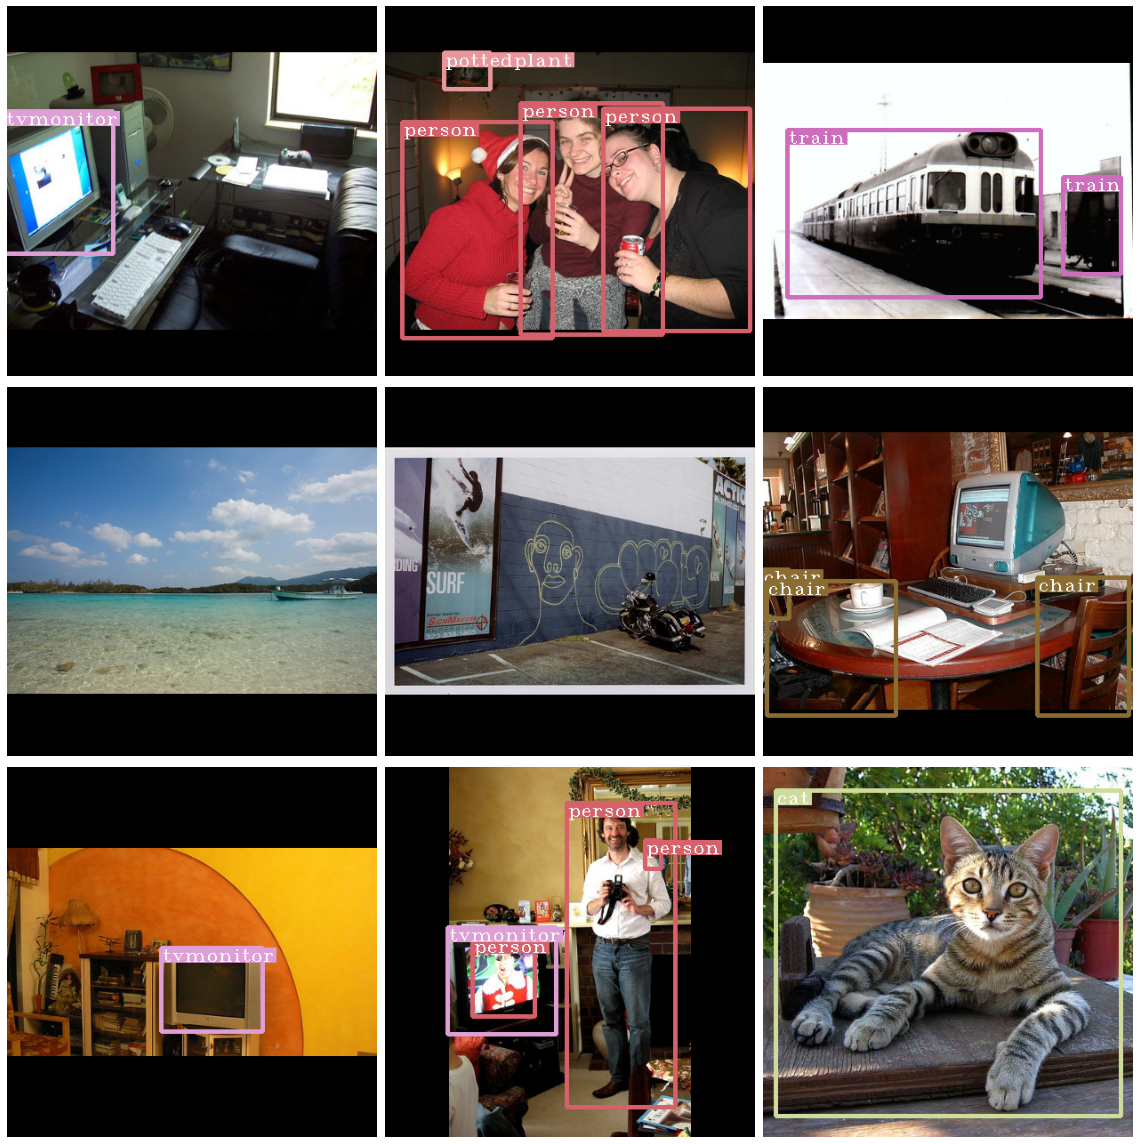

In [14]:
nrows = 3
ncols = 3

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16))

for i in range(nrows):
    for j in range(ncols):
        idx = i*ncols + j
        img, bboxes, _ = nms_predict[idx]
        frame = np.array(inverse(img))
        # Convert bounding boxes' coordiante system
        width = frame.shape[1]
        height = frame.shape[0]
        bboxes = torch.tensor(bboxes)
        if bboxes.size(0):
            bboxes[..., 0] *= width
            bboxes[..., 1] *= height
            bboxes[..., 2] *= width
            bboxes[..., 3] *= height
            bboxes = bboxes.tolist()
            # Draw bounding boxes
            frame = draw_boxes(frame, bboxes, PASCAL_CLASSES)
        axes[i][j].imshow(frame)
        axes[i][j].set_axis_off()

plt.tight_layout()

### Visualize GroundTruth

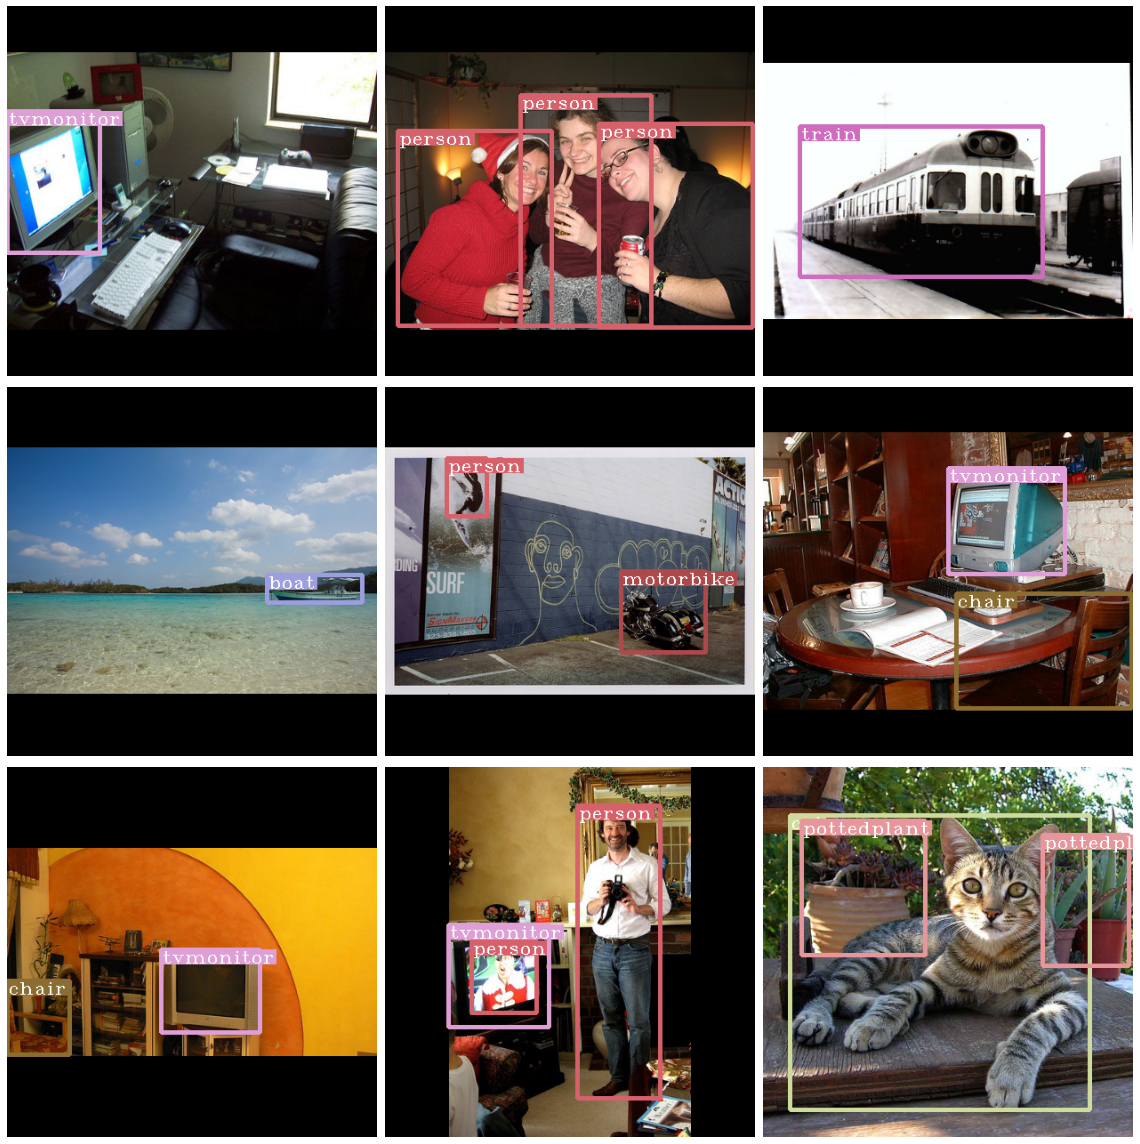

In [15]:
nrows = 3
ncols = 3

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16))

for i in range(nrows):
    for j in range(ncols):
        idx = i*ncols + j
        img, _, bboxes = nms_predict[idx]
        frame = np.array(inverse(img))
        # Convert bounding boxes' coordiante system
        width = frame.shape[1]
        height = frame.shape[0]
        bboxes = torch.tensor(bboxes)
        if bboxes.size(0):
            bboxes[..., 0] *= width
            bboxes[..., 1] *= height
            bboxes[..., 2] *= width
            bboxes[..., 3] *= height
            bboxes = bboxes.tolist()
            # Draw bounding boxes
            frame = draw_boxes(frame, bboxes, PASCAL_CLASSES)
        axes[i][j].imshow(frame)
        axes[i][j].set_axis_off()

plt.tight_layout()